In [13]:
using DrWatson
@quickactivate "Doran_etal_2022"

using CSV, DataFrames, Muon
using SPI
using StatsBase
using StatsPlots
theme(:default, grid=false, label="")
plotlyjs()

include(srcdir("helpers.jl"))

using NewickTree
using NewickTreeTools
include(srcdir("MIcurve_functions.jl"))

collectMI_across_treedepth (generic function with 1 method)

In [6]:
csbdir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "CSB669_MIcurves") |> mkpath
pdir = plotsdir("CSB669_MIcurves") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves"

In [12]:
csbspitree = readnw(open(readline, joinpath(csbdir, "BB669_inferred_spitree_nj.nw")));
csbobs = CSV.read(joinpath(csbdir, "BB669_rowmeta.csv"), DataFrame);

In [57]:
gtdb_cols = [:phylum_gtdb, :class_gtdb, :order_gtdb, :family_gtdb, :genus_gtdb, :species_gtdb, :donor]
ncbi_cols = [:phylum_ncbi, :class_ncbi, :order_ncbi, :family_ncbi, :genus_ncbi, :species_ncbi, :donor]
NCUTS = 100
NBOOT = 50

50

## NCBI taxonomy

In [58]:
rowmeta = csbobs[:, ncbi_cols]
havelabels = vec(mapslices(r->all(r .!= "<unclassified>"), Matrix(rowmeta), dims=2));
IDS = csbobs.ID;

In [59]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:3


  0.515457 seconds (4.99 M allocations: 330.207 MiB, 12.91% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:6


  4.283704 seconds (887.83 k allocations: 2.366 GiB, 8.58% gc time, 5.19% compilation time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:9


265.609117 seconds (6.44 M allocations: 171.056 GiB, 6.25% gc time, 0.06% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:16


  0.146523 seconds (226.02 k allocations: 15.133 MiB, 96.12% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,phylum_ncbi,0.0,0.0
2,phylum_ncbi,0.00114668,2.98658e-5
3,phylum_ncbi,0.002285,4.54082e-5
4,phylum_ncbi,0.0036128,5.30641e-5
5,phylum_ncbi,0.00494281,6.65844e-5
6,phylum_ncbi,0.00728995,7.68694e-5
7,phylum_ncbi,0.00964569,8.14527e-5
8,phylum_ncbi,0.0119999,0.000104221
9,phylum_ncbi,0.0145447,0.000115799


In [60]:
CSV.write(joinpath(rdir, "spi_MI_ncbi.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_ncbi_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_ncbi_bootstraps_aggregated.csv"), boot_SPI_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_ncbi_bootstraps_aggregated.csv"

In [61]:
taxonomylevels = permutedims(string.(ncbi_cols))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

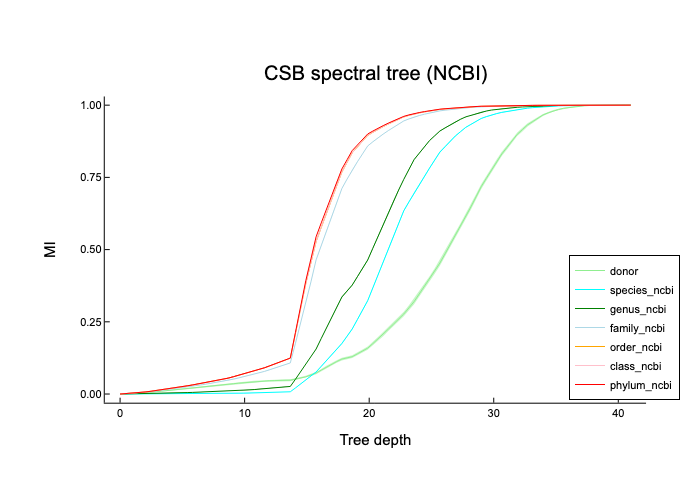

In [62]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (NCBI)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(600,250),  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [63]:
savefig(joinpath(pdir, "CSB_NCBI_MIcurves_boot50_cuts100.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/CSB_NCBI_MIcurves_boot50_cuts100.pdf"

## GTDB taxonomy

In [64]:
rowmeta = csbobs[:, gtdb_cols]
havelabels = vec(mapslices(r->all(r .!= "<unclassified>"), Matrix(rowmeta), dims=2));
IDS = csbobs.ID;

In [65]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:3


  0.571823 seconds (4.99 M allocations: 330.207 MiB, 22.75% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:6


  4.256973 seconds (118.56 k allocations: 2.480 GiB, 5.96% gc time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:9


295.123470 seconds (6.44 M allocations: 182.137 GiB, 12.32% gc time, 0.04% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:16


  0.152089 seconds (226.02 k allocations: 15.131 MiB, 96.17% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,phylum_gtdb,0.0,0.0
2,phylum_gtdb,0.0011604,2.77737e-5
3,phylum_gtdb,0.00231627,3.38452e-5
4,phylum_gtdb,0.00367006,4.12945e-5
5,phylum_gtdb,0.0050206,4.56972e-5
6,phylum_gtdb,0.00741258,5.99453e-5
7,phylum_gtdb,0.00981488,7.20119e-5
8,phylum_gtdb,0.0122075,8.53663e-5
9,phylum_gtdb,0.0148004,8.59134e-5


In [66]:
CSV.write(joinpath(rdir, "spi_MI_gtdb.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_gtdb_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_gtdb_bootstraps_aggregated.csv"), boot_SPI_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_gtdb_bootstraps_aggregated.csv"

In [67]:
taxonomylevels = permutedims(string.(gtdb_cols))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

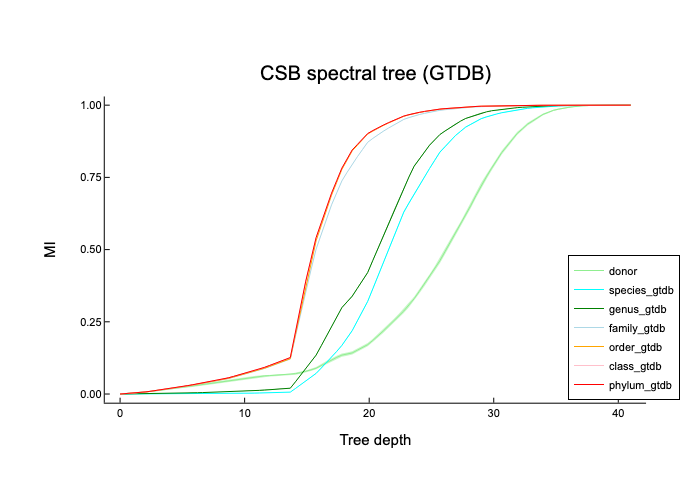

In [68]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (GTDB)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(600,250),  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [69]:
savefig(joinpath(pdir, "CSB_GTDB_MIcurves_boot50_cuts100.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/CSB_GTDB_MIcurves_boot50_cuts100.pdf"